# 가위, 바위, 보!
가위바위보 이미지 데이터셋를 이용해 가위, 바위, 보를 분류해보자
- [Teachable Machine](https://teachablemachine.withgoogle.com/) 사이트에서 직접 데이터셋 생성
- 데이터셋 모음(아이펠 교육생 데이터)[가위바위보 데이터셋](https://www.notion.so/modulabs/E-1-7fbdccfc3f2a453c8cf1670c2e76b7c8)
- TensorFlow를 이용해 딥러닝 모델 구축

### 목차
0. 데이터 확인 : 종류 및 개수 확인, 시각화
1. 데이터 전처리 및 불러오기 : 사이즈 변경, 불러오기, 병합, 변환, Standardization
2. 딥러닝 모델 설계 및 학습 : 정의, 컴파일, 모델학습
3. 결과 확인 : Accuracy, Confusion Matrix, Report

In [35]:
import os
import glob
import random


from sklearn.utils import shuffle
import numpy as np
from tensorflow.keras.layers.experimental import preprocessing

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
from PIL import Image
%matplotlib inline

pont_path = '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf'
fontprop = fm.FontProperties(fname=pont_path, size=18)

# 0. 데이터 확인
- 다른 교육생들과 공유하여 데이터양 Up
- 224x224 이미지를 28x28로 Resize(컬러이미지, Channel = 3)
- 교육생 8명을 학습데이터, 다른 교육생 7명을 테스트 데이터로 사용

In [36]:
TARGET_SIZE = (112, 112)
EPOCH = 15

### 0-1. 데이터 확인 : 종류 및 개수 확인

In [37]:
base_dir = os.getenv("HOME") + '/aiffel/rock_scissor_paper/data'
classes = ['rock', 'scissor', 'paper'] 
train_list = ['사공', '수완', '호성','승민','재성', '지윤', '은서', '정식'] # 8명
test_list = ['민지', '범진', '보경', '영민', '은영', '재준', '효정'] # 7명

print('Name (rock, scissor, paper)')

print('*' * 4, 'Train Dataset', '*' * 8)
for name in train_list: # 이름별 폴더에 하나씩 입장한 후 각 클래스별 개수 count
    len_rock = len(glob.glob(os.path.join(base_dir, name, 'rock/*.jpg')))
    len_scissor = len(glob.glob(os.path.join(base_dir, name, 'scissor/*.jpg')))
    len_paper = len(glob.glob(os.path.join(base_dir, name, 'paper/*.jpg')))
    print(name, (len_rock, len_scissor, len_paper))

print('*' * 4, 'Test Dataset', '*' * 8)
for name in test_list: # 이름별 폴더에 하나씩 입장한 후 각 클래스별 개수 count
    len_rock = len(glob.glob(os.path.join(base_dir, name, 'rock/*.jpg')))
    len_scissor = len(glob.glob(os.path.join(base_dir, name, 'scissor/*.jpg')))
    len_paper = len(glob.glob(os.path.join(base_dir, name, 'paper/*.jpg')))
    
    print(name, (len_rock, len_scissor, len_paper))

Name (rock, scissor, paper)
**** Train Dataset ********
사공 (122, 111, 117)
수완 (101, 102, 102)
호성 (100, 100, 100)
승민 (100, 100, 100)
재성 (100, 100, 100)
지윤 (100, 100, 100)
은서 (103, 101, 103)
정식 (106, 113, 105)
**** Test Dataset ********
민지 (100, 100, 100)
범진 (100, 100, 100)
보경 (100, 100, 100)
영민 (100, 100, 100)
은영 (100, 100, 100)
재준 (100, 100, 100)
효정 (101, 101, 101)


### 0-1. 데이터 확인 : 시각화

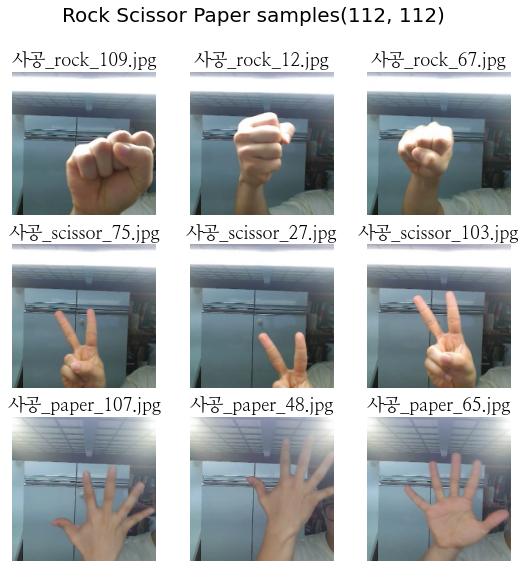

In [38]:
def get_image_sample(name, cls, sample=3): # 이름(name)과 클래스(cls)에 맞는 데이터 불러오기
    image_dir = os.path.join(base_dir, name, cls)
    image_list = glob.glob(image_dir + '/*.jpg')
    
    samples = random.sample(image_list, sample) # 이미지 파일들 중 랜덤으로 sample개 고르기
    
    return samples

# 클래스별 3개씩 가져오기
rock_samples = get_image_sample('사공', 'rock')
scissor_samples = get_image_sample('사공', 'scissor')
paper_samples = get_image_sample('사공', 'paper')

# 병합
sample_list = rock_samples + scissor_samples + paper_samples

plt.figure(figsize=(9,9))
plt.suptitle(F'Rock Scissor Paper samples{TARGET_SIZE}', fontsize=20)
for i, image_path in enumerate(sample_list):
    image = Image.open(image_path)
    filename = image_path.split('/')[-1] # 파일명만 추출(url에 있는 \로 split 후 가장 뒤에 파일명만 추출)
    
    plt.subplot(3, 3, i+1)
    plt.imshow(image)
    plt.title(filename, fontproperties=fontprop)
    plt.axis('off')

# 1. 데이터 전처리 및 불러오기
분석에 활용할 수 있도록 데이터를 전처리를 한 후 불러왔다.
1. 데이터 사이즈 변경(228x228 to 114x114)
2. 각각의 이미지 데이터를 불러온 후 병합 및 배열(array) 자료형으로 변환
3. Normalization 적용(tensorflow Layer 활용)
3. Exploration 1-7노드에 있는 코드를 참고

#### 변경 사항
- 데이터의 총 개수가 달라져도 오류가 나지 않도록 ```load_data()```함수 수정
- 원하는 데이터 사이즈로 자유롭게 수정할 수 있도록 ```resize_image()```함수 수정

### 1-1. 데이터 전처리 :  사이즈 변경
- ```resize_image()``` 함수 수정
- 사이즈가 수정된 이미지를 저장하지 않고 바로 사용
 - 원본 : 224x224
 - 수정 : 28x28

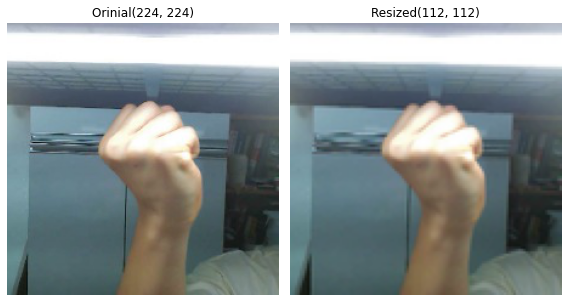

In [39]:
def resize_image(old_image, target_size=TARGET_SIZE): # target_size에 원하는 사이즈 설정
    target_size = target_size
    new_image = old_image.resize(target_size, Image.ANTIALIAS)
    
    return new_image

sample_path = get_image_sample('사공', 'rock', sample=1)[0] # 위에서 정의한 get_image_sample함수
sample_image = Image.open(sample_path)
sample_resized = resize_image(sample_image)

plt.figure(figsize=(8,8))

plt.subplot(1,2,1)
plt.imshow(sample_image)
plt.title(f'Orinial{sample_image.size}')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(sample_resized)
plt.title(f'Resized{sample_resized.size}')
plt.axis('off')

plt.tight_layout()
plt.show()

### 1-2. 데이터 전처리 : 불러오기 및 병합, 변환
- ```load_data()```함수는 노드에 있는 코드 활용
- 데이터 개수와 사이즈를 자유롭게 변경할 수 있도록 ```load_data()``` 코드 수정
- 데이터를 한 곳으로 병합 및 배열(array) 자료형으로 변환

In [40]:
def load_data(img_path, target_size=TARGET_SIZE, color=3): # 자유롭게 사이즈 및 channel 수정 가능
    
    # 데이터의 총 개수 계산
    number_of_data = 0
    for dirpath, dirnames, filenames in os.walk(img_path): 
        number_of_data += len(filenames)
        
    imgs = np.zeros((number_of_data, *target_size, color), dtype=np.int32) # 코드 수정(생성과 reshape를 한 번에!)
    labels = np.zeros(number_of_data, dtype=np.int32)
    idx=0 # 가위 : 0, 바위 : 1, 보 : 2
    for file in glob.iglob(img_path + '/scissor/*.jpg'):
        img = Image.open(file)
        resized_img = resize_image(img, target_size=target_size)
        imgs[idx,:,:,:] = np.array(resized_img, dtype=np.int32)    # 데이터 영역에 이미지 행렬을 복사
        labels[idx] = 0   # 가위 : 0
        idx = idx + 1

    for file in glob.iglob(img_path + '/rock/*.jpg'):
        img = Image.open(file)
        resized_img = resize_image(img, target_size=target_size)
        imgs[idx,:,:,:] = np.array(resized_img, dtype=np.int32)    # 데이터 영역에 이미지 행렬을 복사
        labels[idx] = 1   # 바위 : 1
        idx = idx + 1  
    
    for file in glob.iglob(img_path + '/paper/*.jpg'):
        img = Image.open(file)
        resized_img = resize_image(img, target_size=target_size)
        imgs[idx,:,:,:] = np.array(resized_img, dtype=np.int32)    # 데이터 영역에 이미지 행렬을 복사
        labels[idx] = 2   # 보 : 2
        idx = idx + 1
        
    return imgs, labels

**불러오기**

In [41]:
train_list = ['사공', '수완', '호성','승민','재성', '지윤', '은서', '정식'] # 학습 데이터 참여 명단
test_list = ['민지', '범진', '보경', '영민', '은영', '재준', '효정'] # 테스트 데이터 참여 명단

train_image_list, train_label_list = [], [] # 이름별 학습 데이터의 집합(리스트)
test_image_list, test_label_list = [], [] # 이름별 테스트 데이터의 집합(리스트)

base_dir = os.getenv("HOME") + '/aiffel/rock_scissor_paper/data'

for train_name in train_list:
    train_dir = os.path.join(base_dir, train_name)               
    train, label = load_data(train_dir, target_size=TARGET_SIZE) # 위에 정의한 load_data()
    train_image_list.append(train)
    train_label_list.append(label)
    
for test_name in test_list:
    test_dir = os.path.join(base_dir, test_name)
    test, label = load_data(test_dir, target_size=TARGET_SIZE)     # 위에 정의한 load_data()
    test_image_list.append(test)
    test_label_list.append(label)

**데이터 병합**

In [42]:
# 이름별 학습 및 테스트 데이터 집합을 합치고 배열(array)로 변환
x_train = np.concatenate(train_image_list, axis=0)
y_train = np.concatenate(train_label_list, axis=0)
x_test = np.concatenate(test_image_list, axis=0)
y_test = np.concatenate(test_label_list, axis=0)

x_train, y_train = shuffle(x_train, y_train) # 학습이 골고루 될 수 있도록 데이터 섞기
# x_test, y_test = shuffle(x_test, y_test)   # 테스트 데이터의 경우 연산의 결과만 보기 때문에 불필요

print(x_train.shape)

(2486, 112, 112, 3)


### 1-3. 데이터 전처리 : 정규화 적용
- 이미지 데이터를 255로 나눠서 0과 1사이의 값으로 정규화

In [43]:
normed_x_train, normed_x_test = (x_train / 255.0), (x_test / 255.0)

print(f'Train Dataset : {normed_x_train.shape}')
print(f'Test Dataset : {normed_x_test.shape}') 
print(f'Max&Min value is : {normed_x_train.max()} / {normed_x_train.mean()}')

Train Dataset : (2486, 112, 112, 3)
Test Dataset : (2103, 112, 112, 3)
Max&Min value is : 1.0 / 0.5293378544515851


### 1-4. 데이터 전처리 : 시각화

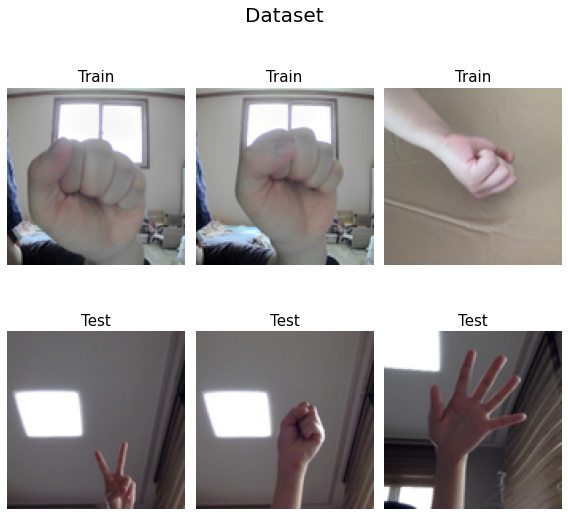

In [44]:
sample_train_images = [x_train[20], x_train[120], x_train[220]]
sample_test_images = [x_test[60], x_test[110], x_test[210]]
sample_images = sample_train_images + sample_test_images

plt.figure(figsize=(8,8))
plt.suptitle("Dataset", fontsize=20)

for i, image in enumerate(sample_images):
    plt.subplot(2, 3, i+1)
    plt.imshow(image)
    plt.title('Train' if i < 3 else 'Test', fontsize=15)
    plt.axis('off')   
    
plt.tight_layout() # 각 사진들의 간격을 최소화

# 2. 딥러닝 모델 설계 및 학습
Tensorflow API를 이용해 가위바위보를 인식하는 딥러닝 모델을 설계 및 학습
#### 주요특징
- 하이퍼파라미터를 바꿔가면서 성능이 가장 좋은 모델 찾기
- 직접 여러 Layer를 쌓아서 모델 정의
- 과적합(Overfitting) 문제를 해결하기 위해 모델 복잡도 낮추기

### 2-1. 모델 설계 : 정의
- 여러 Layer를 쌓아서 딥러닝 모델 정의
- CNN과 Linear Layer를 적절히 사용

In [45]:
import tensorflow as tf
from tensorflow import keras

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(8, (3, 3), activation='relu', input_shape=(*TARGET_SIZE, 3)))
model.add(keras.layers.MaxPool2D(2, 2))
model.add(keras.layers.Conv2D(8, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 110, 110, 8)       224       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 55, 55, 8)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 53, 53, 8)         584       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 26, 26, 8)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                86544     
_________________________________________________________________
dense_7 (Dense)              (None, 32)               

### 2-2. 모델 설계 : 컴파일
- 최적화 함수 및 손실 함수를 정의

In [46]:
model.compile(optimizer='adam',                         # adam 옵티마이저 사용
             loss='sparse_categorical_crossentropy',   # CrossEntroyLoss 손실함수 사용
             metrics=['accuracy'], )

### 2-3. 모델 학습

In [47]:
history = model.fit(normed_x_train, y_train, epochs=EPOCH)

Epoch 1/15
78/78 [==============================] - 6s 42ms/step - loss: 1.0663 - accuracy: 0.4265
Epoch 2/15
78/78 [==============================] - 1s 8ms/step - loss: 0.6134 - accuracy: 0.7582
Epoch 3/15
78/78 [==============================] - 1s 8ms/step - loss: 0.2716 - accuracy: 0.9088
Epoch 4/15
78/78 [==============================] - 1s 8ms/step - loss: 0.1343 - accuracy: 0.9677
Epoch 5/15
78/78 [==============================] - 1s 8ms/step - loss: 0.0772 - accuracy: 0.9848
Epoch 6/15
78/78 [==============================] - 1s 8ms/step - loss: 0.0459 - accuracy: 0.9895
Epoch 7/15
78/78 [==============================] - 1s 8ms/step - loss: 0.0226 - accuracy: 0.9956
Epoch 8/15
78/78 [==============================] - 1s 8ms/step - loss: 0.0171 - accuracy: 0.9977
Epoch 9/15
78/78 [==============================] - 1s 8ms/step - loss: 0.0157 - accuracy: 0.9960
Epoch 10/15
78/78 [==============================] - 1s 8ms/step - loss: 0.0094 - accuracy: 0.9988
Epoch 11/15
78/78 

# 3. 학습 결과 확인
- Train 및 Test 정확도 확인
- Confusion Matrix 확인
- Confusion Matrix Report 확인

### Test 정확도 확인

In [31]:
from tensorflow.math import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd

test_loss, test_accuracy = model.evaluate(normed_x_test, y_test, verbose=0)
print(f"Test_accuracy: {(test_accuracy * 100):.4f}%%")

Test_accuracy: 37.4227%%


### Confusion Matrix Report 확인

In [32]:
y_pred = np.argmax(model.predict(normed_x_test), axis=1) # 예측결과(각 샘플 당 3개) 중 가장 높은 값
                                                         # 이 값이 결국 클래스를 의미
_confusion_report = classification_report(y_test, y_pred, 
                                          target_names=['가위', '바위', '보'], 
                                          output_dict=True) # dict 형태로 출력(dataframe 만들기 위해)
pd.DataFrame(_confusion_report)

,가위,바위,보,accuracy,macro avg,weighted avg
precision,0.350592,0.385502,0.385366,0.374227,0.373820,0.373820
recall,0.338088,0.333809,0.450785,0.374227,0.374227,0.374227
f1-score,0.344227,0.357798,0.415516,0.374227,0.372514,0.372514
support,701.000000,701.000000,701.000000,0.374227,2103.000000,2103.000000


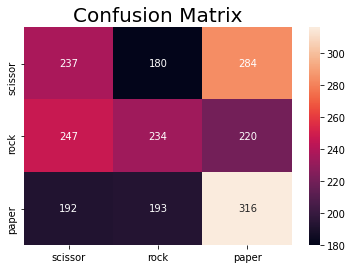

In [33]:
import seaborn as sns

_confusion_matrix = confusion_matrix(y_test, y_pred) # Confusion Matrix 만들기
df_confusion = pd.DataFrame(_confusion_matrix.numpy(),
                           columns=['scissor', 'rock', 'paper'],
                           index=['scissor', 'rock', 'paper'])
sns.heatmap(df_confusion, annot=True, fmt='g') # Confusion Matrix를 heatmap으로 시각화
plt.title('Confusion Matrix', fontsize=20)
plt.show()

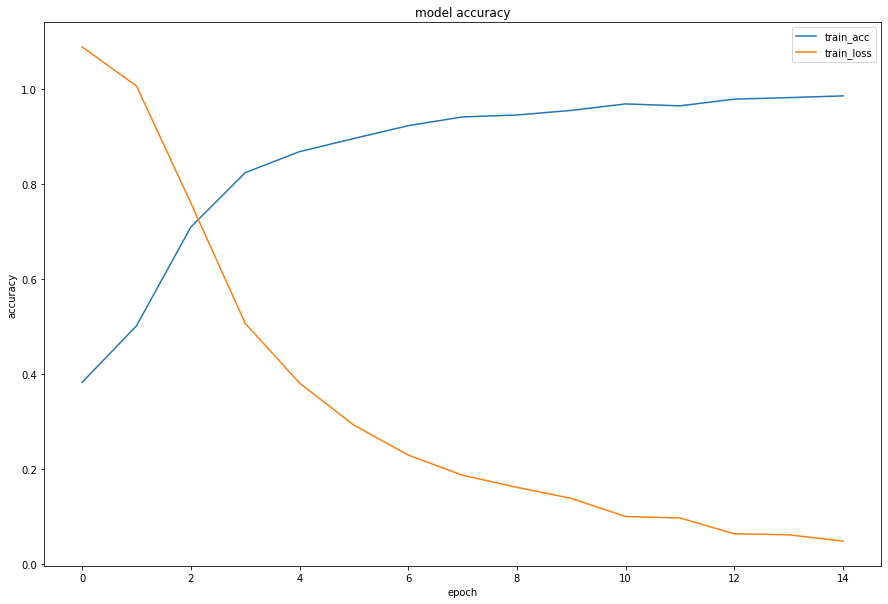

In [34]:
# 모델의 Loss, Accuracy값 시각화
plt.figure(figsize=(15,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'train_loss'], loc='upper right')

# 정확도 향상을 위한 노력
1. 데이터 개수 추가
2. 데이터의 사이즈 증가
3. 전이학습 (VGG16 모델)

### 1. 데이터 개수 추가
- 1명에서 8명으로 학습데이터 추가
- 1명에서 7명으로 테스트 데이터 추가
- 테스트 결과에 대한 신빙성 높이기

![title]("images/picture.png")

### 2. 데이터 사이즈 증가
- 데이터의 사이즈를 28x28에서 112x112 또는 224x224로 학습시켜 진행
- 아래는 학습 후 결과만 표시

In [48]:
TARGET_SIZE = (112, 112)

In [49]:
test_loss_resized, test_accuracy_resized = model.evaluate(normed_x_test, y_test, verbose=0)
pd.DataFrame({'28x28' : (test_accuracy * 100),
              '112x112' : (test_accuracy_resized * 100)}, index=['Accuracy'])

,28x28,112x112
Accuracy,37.422729,38.563955


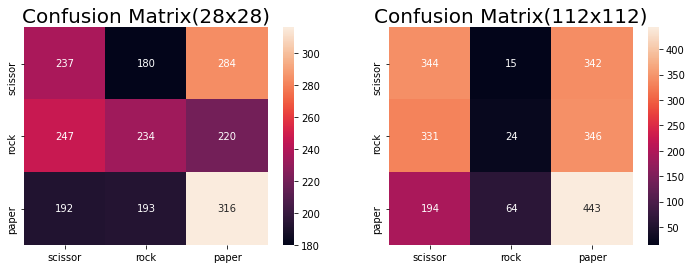

In [50]:
import seaborn as sns
y_pred_resized = np.argmax(model.predict(normed_x_test), axis=1)
                                                         
_confusion_matrix_resized = confusion_matrix(y_test, y_pred_resized)
df_confusion_resized = pd.DataFrame(_confusion_matrix_resized.numpy(),
                                    columns=['scissor', 'rock', 'paper'],
                                    index=['scissor', 'rock', 'paper'])

plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
sns.heatmap(df_confusion, annot=True, fmt='g')
plt.title('Confusion Matrix(28x28)', fontsize=20)

plt.subplot(1,2,2)
sns.heatmap(df_confusion_resized, annot=True, fmt='g')
plt.title('Confusion Matrix(112x112)', fontsize=20)

plt.show()

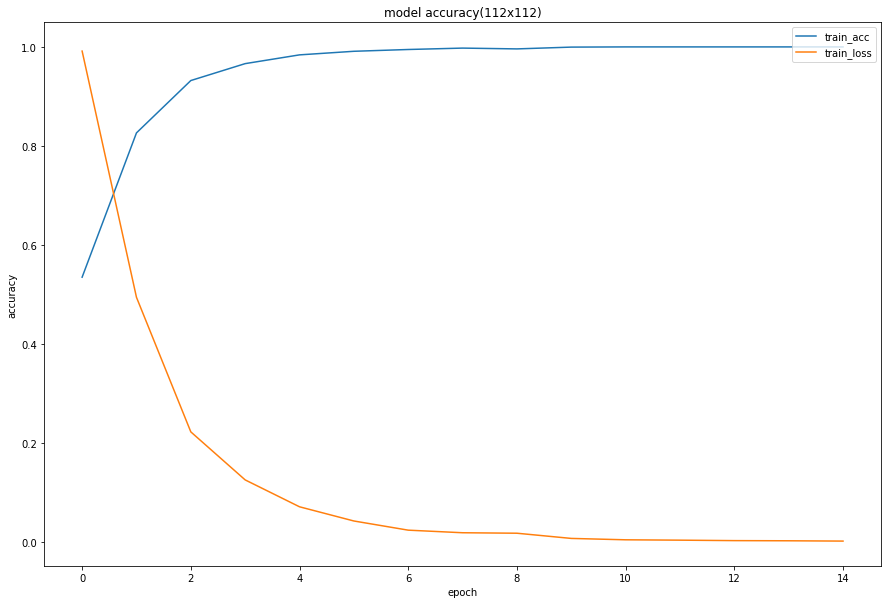

In [51]:
# 모델의 Loss, Accuracy값 시각화
plt.figure(figsize=(15,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

plt.title('model accuracy(112x112)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'train_loss'], loc='upper right')

### 전이학습(VGG16 모델)
- 외부 유명한 모델을 이용해 전이학습 시도
- Backbone 모델은 ImageNet으로 학습된 가중치 사용
- Backbone은 학습하지 않고 Classifier부분만 정의 후 학습
- 이미지 사이즈는 112x112 사용

In [52]:
from tensorflow.keras.applications import VGG16

model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(112,112, 3)) # vgg16 불러오기
model_vgg.trainable = False                                                        # Backbone 학습x

model = keras.models.Sequential()
model.add(model_vgg)                                                                # Backbone 모델 추가
model.add(keras.layers.Flatten())                    
model.add(keras.layers.Dense(4096, activation='relu', kernel_regularizer='l2'))     # Classifier 정의
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(4096, activation='relu', kernel_regularizer='l2'))     # l2 : l2 Norm
model.add(keras.layers.Dropout(0.5))                                                # Regularization
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 4096)              18878464  
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 3)                

In [54]:
EPOCH = 10
model.compile(optimizer='adam',                         
             loss='sparse_categorical_crossentropy', 
             metrics=['accuracy'], )

history = model.fit(normed_x_train, y_train, epochs=EPOCH)

Epoch 1/10
78/78 [==============================] - 15s 188ms/step - loss: 38.6382 - accuracy: 0.6925
Epoch 2/10
78/78 [==============================] - 7s 92ms/step - loss: 2.9049 - accuracy: 0.9617
Epoch 3/10
78/78 [==============================] - 7s 93ms/step - loss: 0.9439 - accuracy: 0.9777
Epoch 4/10
78/78 [==============================] - 7s 93ms/step - loss: 0.5164 - accuracy: 0.9763
Epoch 5/10
78/78 [==============================] - 7s 93ms/step - loss: 0.4819 - accuracy: 0.9679
Epoch 6/10
78/78 [==============================] - 7s 93ms/step - loss: 0.3374 - accuracy: 0.9845
Epoch 7/10
78/78 [==============================] - 7s 93ms/step - loss: 0.2818 - accuracy: 0.9768
Epoch 8/10
78/78 [==============================] - 7s 93ms/step - loss: 0.3150 - accuracy: 0.9721
Epoch 9/10
78/78 [==============================] - 7s 93ms/step - loss: 0.2811 - accuracy: 0.9802
Epoch 10/10
78/78 [==============================] - 7s 93ms/step - loss: 0.2540 - accuracy: 0.9744


In [55]:
test_loss_resized, test_accuracy_vgg16 = model.evaluate(normed_x_test, y_test, verbose=0)
pd.DataFrame({'28x28' : (test_accuracy * 100),
              '112x112' : (test_accuracy_resized * 100),
              'VGG16' : (test_accuracy_vgg16 * 100)}, index=['Accuracy'])

,28x28,112x112,VGG16
Accuracy,37.422729,38.563955,77.983832


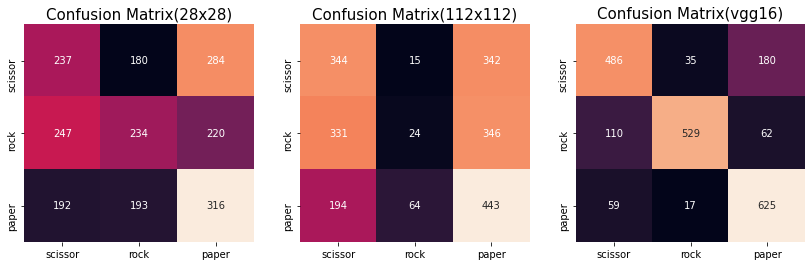

In [56]:
import seaborn as sns
y_pred_vgg16 = np.argmax(model.predict(normed_x_test), axis=1) # 예측결과(각 샘플 당 3개) 중 가장 높은 값
                                                         # 이 값이 결국 클래스를 의미
_confusion_matrix_vgg16 = confusion_matrix(y_test, y_pred_vgg16) # Confusion Matrix 만들기
df_confusion_vgg16 = pd.DataFrame(_confusion_matrix_vgg16.numpy(),
                           columns=['scissor', 'rock', 'paper'],
                           index=['scissor', 'rock', 'paper'])

plt.figure(figsize=(14, 4))
plt.subplot(1,3,1)
sns.heatmap(df_confusion, annot=True, fmt='g', cbar=False) # Confusion Matrix를 heatmap으로 시각화
plt.title('Confusion Matrix(28x28)', fontsize=15)

plt.subplot(1,3,2)
sns.heatmap(df_confusion_resized, annot=True, fmt='g', cbar=False) # Confusion Matrix를 heatmap으로 시각화
plt.title('Confusion Matrix(112x112)', fontsize=15)

plt.subplot(1,3,3)
sns.heatmap(df_confusion_vgg16, annot=True, fmt='g', cbar=False) # Confusion Matrix를 heatmap으로 시각화
plt.title('Confusion Matrix(vgg16)', fontsize=15)
plt.show()

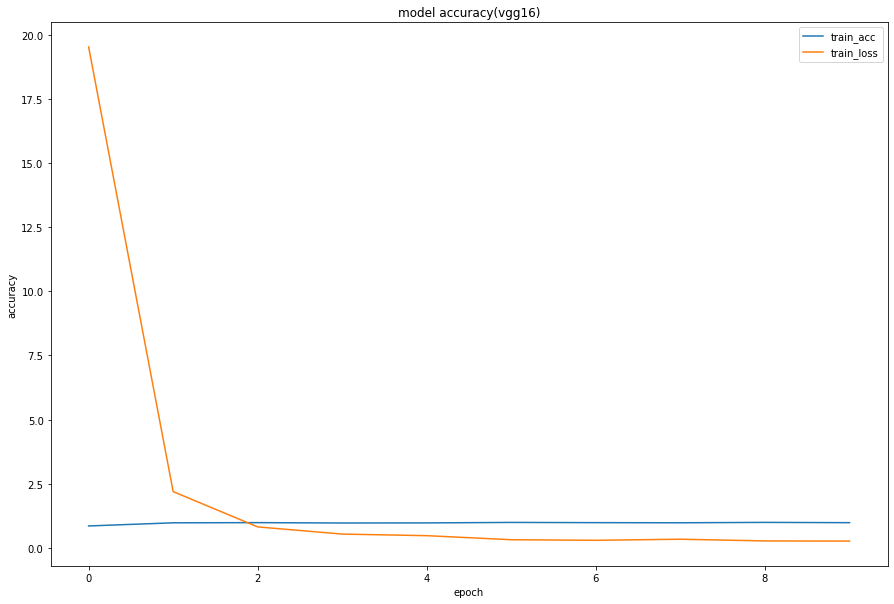

In [57]:
# 모델의 Loss, Accuracy값 시각화
plt.figure(figsize=(15,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

plt.title('model accuracy(vgg16)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'train_loss'], loc='upper right')